In [1]:
SAVE = True
SAVE_PATH = 'r_figs/'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# source: https://data.oecd.org/interest/long-term-interest-rates.htm
i = pd.read_excel('manual_data/ltrate.xlsx', sheet_name='ltrate - annual')
i = pd.pivot_table(i, columns='LOCATION', index='TIME', values='Value')
i.index.name = 'year'
i.columns.name = 'oecd country code'

# source (I think): https://data.worldbank.org/indicator/NY.GDP.MKTP.CN?end=2020&locations=OE&start=2020&view=bar
ngdp = pd.read_excel('manual_data/ngdp.xlsx', index_col=1, header=0).T
ngdp = ngdp.iloc[3:]
ngdp.index.name = 'year'
ngdp.columns.name = 'wb country code'

data = {}

for country in i:
    if country in ngdp:
        # confirmed that country codes line up, and we want inner join
        data[country] = {}
        data[country]['i'] = i[country]/100
        data[country]['ngdp'] = ngdp[country].astype(float)
        data[country]['ngdp_growth_next10'] = (ngdp[country].shift(-10)/ngdp[country])**.1 - 1
        data[country]['ngdp_growth_next10'] = data[country]['ngdp_growth_next10'].astype(float)
        data[country] = pd.DataFrame(data[country])
        data[country]['country'] = country
        data[country]['year'] = data[country].index


corr = {}
for country in data:
    x = data[country]['i'].dropna().corr(data[country]['ngdp_growth_next10'].dropna())
    corr[country] = x
corr = pd.Series(corr)


countries = ['USA', 'AUS', 'CAN', 'DEU', 'FRA', 'GBR', 'JPN']

# stack for desired countries
tmp = [v for k,v in data.items() if k in countries]
tmp = pd.concat(tmp, axis=0)

min_year = tmp.dropna().groupby('country').apply(lambda x: x.index.min())
max_year = tmp.dropna().groupby('country').apply(lambda x: x.index.max())
time = pd.DataFrame({
    'min': min_year,
    'max': max_year,
    'count': max_year - min_year
}).sort_values('min', ascending=True)

In [3]:
stacked = pd.concat([v for k,v in data.items()], axis=0)
stacked = stacked[
    (stacked['i'] < 0.3)
]  # winsorize

In [4]:
minimum = min(stacked['i'].min(), stacked['ngdp_growth_next10'].min()) - 0.01
maximum = max(stacked['i'].max(), stacked['ngdp_growth_next10'].max()) + 0.01

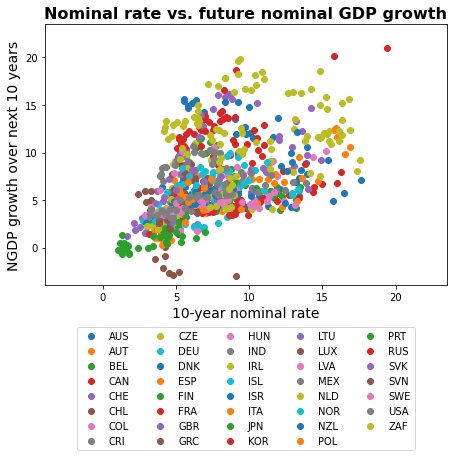

In [5]:
frac = 60
fig = plt.subplots(1, figsize=(432/frac, 288/frac))
if maximum < 1:
    minimum *= 100 # go from decimal to percent
    maximum *= 100 # go from decimal to percent
plt.ylim(minimum, maximum)
plt.xlim(minimum, maximum)
plt.xlabel('10-year nominal rate', fontsize=14)
plt.ylabel('NGDP growth over next 10 years', fontsize=14)
for country in data:
    tmp = data[country]
    tmp = tmp[
        (tmp['i'] < 0.3)
    ]
    tmp *= 100    # go from decimal to percent
    plt.scatter(tmp['i'], tmp['ngdp_growth_next10'], label=country)
plt.legend(
    bbox_to_anchor=[0.5,-0.65], 
    loc='lower center',
    ncol=5,
)
plt.title("Nominal rate vs. future nominal GDP growth", fontsize=16, weight='heavy')
if SAVE:
    plt.savefig(SAVE_PATH + 'oecd.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [6]:
import statsmodels.api as sm
reg = sm.OLS.from_formula(formula='ngdp_growth_next10 ~ i + C(country)', data=stacked).fit()
reg2 = sm.OLS.from_formula(formula='ngdp_growth_next10 ~ i', data=stacked).fit()
reg3 = sm.OLS.from_formula(formula='ngdp_growth_next10 ~ i + C(country) + C(year)', data=stacked).fit()

C:\Users\basil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\basil\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
